# Time Series Analysis of Temperature

Global warming is the ongoing rise of the average temperature of the Earth's climate system and has been demonstrated by direct temperature measurements and by measurements of various effects of the warming - Wikipedia

So a dataset on the temperature of major cities of the world will help analyze the same. Also weather information is helpful for a lot of data science tasks like sales forecasting, logistics etc.

# 1. Data and preprocessing 

Data comes from Kaggle and it could be reached from [here](https://www.kaggle.com/sudalairajkumar/daily-temperature-of-major-cities). Thanks to University of Dayton, the dataset is available as separate txt files for each city. The data is available for research and non-commercial purposes only. Please refer to [this page](http://academic.udayton.edu/kissock/http/Weather/default.htm) for license.

 In this dataset, it includes daily average temperature values collected as Fahrenheit over different regions, countries, cities over the years from about 1995 to 2020.

In [43]:
# Setup
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')
import pmdarima as pm

In [44]:
df = pd.read_csv('city_temperature.csv')

Since the data includes many cities, I select only Istanbul from the list. 

In [45]:
df= df[(df.Country =='Turkey') & (df.City == 'Istanbul')]
df.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature
1102318,Middle East,Turkey,NaN,Istanbul,1,1,1995,55.0
1102319,Middle East,Turkey,NaN,Istanbul,1,2,1995,57.1
1102320,Middle East,Turkey,NaN,Istanbul,1,3,1995,44.4
1102321,Middle East,Turkey,NaN,Istanbul,1,4,1995,47.6
1102322,Middle East,Turkey,NaN,Istanbul,1,5,1995,44.1


### Missing values
During the EDA, some values in temperature are missing (-99). Let's first check out how many variables are missing. We noticed that there are 30 values are missing and we replace then with ffill function. 

In [46]:
"""-99 is put in place of missing values. 
We will have to forward fill with the last non missing value before -99
"""
df["AvgTemperature"] = np.where(df["AvgTemperature"] == -99, np.nan, df["AvgTemperature"])
df.isnull().sum()



Region               0
Country              0
State             9266
City                 0
Month                0
Day                  0
Year                 0
AvgTemperature      30
dtype: int64

In [47]:
df["AvgTemperature"] = df["AvgTemperature"].ffill()
df.isnull().sum()

Region               0
Country              0
State             9266
City                 0
Month                0
Day                  0
Year                 0
AvgTemperature       0
dtype: int64

### Celsius Conversion 
Finally, we can convert AvgTemperature from Fahrenhei to Celsius

Formula (°F − 32) × 5/9.

In [48]:
df['AvgTemperature'] = (df['AvgTemperature']  -32) * 5/9 


### Basic graphs about temperature in Istanbul

Text(0.5, 1.0, 'Istanbul Temperature Measurements by Year')

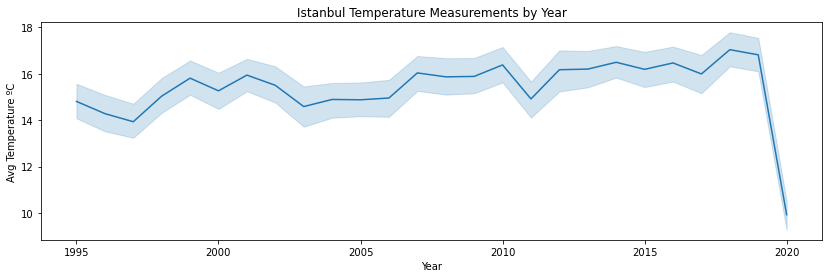

In [49]:
sns.lineplot(x = df["Year"], y = df["AvgTemperature"])
plt.ylabel("Avg Temperature ºC")
plt.title("Istanbul Temperature Measurements by Year")

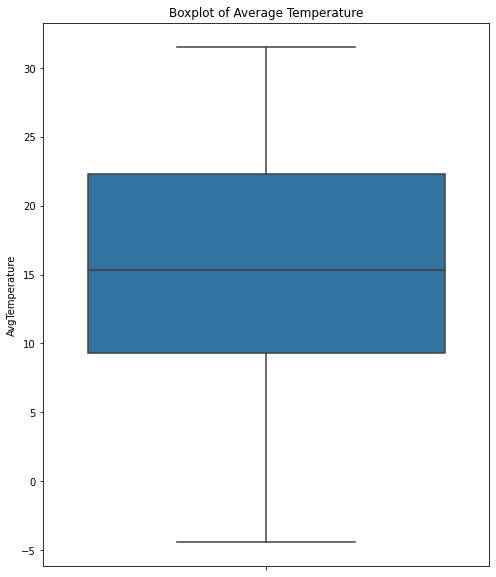

In [50]:
plt.figure(figsize = (8,10))
sns.boxplot(data = df,y = 'AvgTemperature')
_=plt.title("Boxplot of Average Temperature")

### Date process

The Year, Month and Day comes as a separate column, I merged them and create a new date variable. 

In [51]:
def make_date(row):
    return datetime(year = row['Year'], month = row['Month'], day = row['Day'])


df['Date'] = df.apply(make_date,axis=1)
df.set_index(df.Date,inplace=True)

We do not need all columns, so I only select temperature and date columns from the data set. I also make data column as the index. Here is the head and tail of the data set. 

In [52]:

df = df[['AvgTemperature', 'Date']]

df.set_index('Date', inplace= True)

print(df.head())
print(df.tail())


            AvgTemperature
Date                      
1995-01-01       12.777778
1995-01-02       13.944444
1995-01-03        6.888889
1995-01-04        8.666667
1995-01-05        6.722222
            AvgTemperature
Date                      
2020-05-09       15.888889
2020-05-10       17.500000
2020-05-11       20.500000
2020-05-12       21.944444
2020-05-13       17.944444


Since 2020 is incomplete, let's strip it off for the current analysis



In [53]:
df= df['1996':'2019']
df.tail()

,AvgTemperature
Date,
2019-12-27,7.666667
2019-12-28,4.944444
2019-12-29,5.277778
2019-12-30,7.944444
2019-12-31,5.888889


# EDA

For EDA analysis, we create two more data set, annual and monthly average of temperature. 

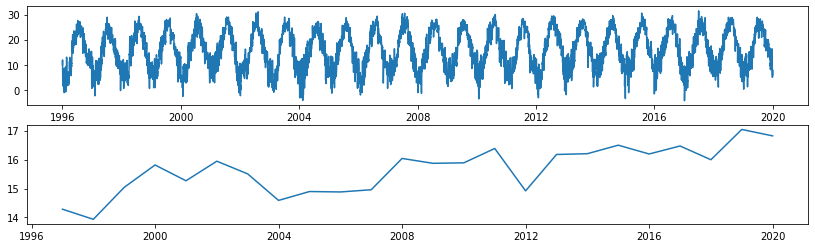

In [54]:
# resample to annual and plot each
plt.rcParams['figure.figsize'] = [14, 4]
annual = df.resample('A').mean()
monthly = df.resample('M').mean()



fig, axes = plt.subplots(2,1)
axes[0].plot(df)
axes[1].plot(annual)

It seems that mean of annual temprature increse a little bit in recent years. 

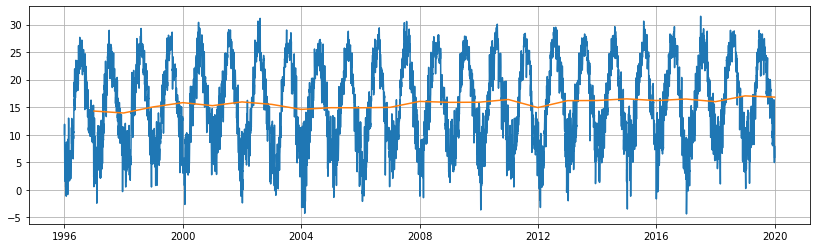

In [55]:
# plot both on same figure
plt.plot(df)
plt.plot(annual)
plt.grid(b=True);

When we combine two graph together, the yellow line represents the annual mean average of the tempreture and blue represents the seasonal tempreture change. The results show that there is no major change in tempreture across years. 

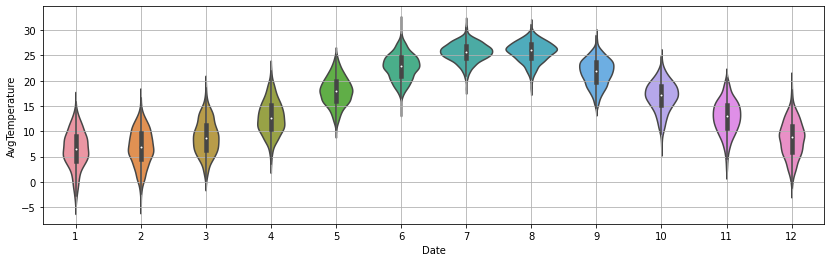

In [56]:
# violinplot of months to determine variance and range
sns.violinplot(x=df.index.month, y=df.AvgTemperature)
plt.grid(b=True);

When we look at the montly change in tempreture, it varies across months. So, we need to consider seasonal variation in this data set. 

In [57]:
# split data into 11 chunks
chunks = np.split(df.AvgTemperature, indices_or_sections=11)

In [58]:
mean_vals = np.mean(chunks,axis=1)
var_vals = np.var(chunks,axis=1)
vals = {'mean_vals': mean_vals , 'var_vals': var_vals}
mean_var = pd.DataFrame(vals)
mean_var

,mean_vals,var_vals
0,13.506413,53.894920
1,15.019169,54.422906
2,16.310470,53.712467
3,15.436359,62.909030
4,15.057507,55.715403
5,15.280775,57.977077
6,15.383312,55.972946
7,16.037990,59.642519
8,16.926182,54.353369
9,16.658511,57.671445


### Dickey–Fuller test

In statistics, the Dickey–Fuller test tests the null hypothesis that a unit root is present in an autoregressive time series model. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity. The test is named after the statisticians David Dickey and Wayne Fuller, who developed it in 1979 (Wikipedia).

- Null hypothesis: the series is nonstationary.  
- Alternative hypothesis: the series is stationary.  

Like any statistical test you should set a significance level or threshold that determines whether you should accept or reject the null.

The value 0.05 is common but depends upons numerous factors.

In [59]:
# define Dickey-Fuller Test (DFT) function
# Null is that unit root is present, rejection means likely stationary

import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries,)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)

Test Statistic         -6.333713e+00
p-value                 2.864637e-08
Lags Used               3.300000e+01
Observations Used       8.733000e+03
Critical Value (1%)    -3.431099e+00
Critical Value (5%)    -2.861871e+00
Critical Value (10%)   -2.566946e+00
dtype: float64


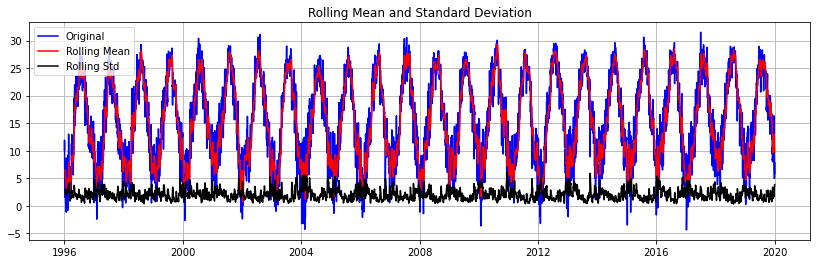

In [60]:
# run DFT on daily
dftest(df.AvgTemperature)
# p-value allows us to reject a unit root: data is stationary

Results indicate that the moving average (rolling mean) and original mean converge pretty good and standard deviation is also smooth. Since we know that there is a seasonal variation in tempreture, the average of 12 month makes the lines more smooter. We can conclude that the mean and variance of the data is almost constant and does not vary much.

Test Statistic           -2.438554
p-value                   0.131149
Lags Used                11.000000
Observations Used       276.000000
Critical Value (1%)      -3.454267
Critical Value (5%)      -2.872070
Critical Value (10%)     -2.572381
dtype: float64


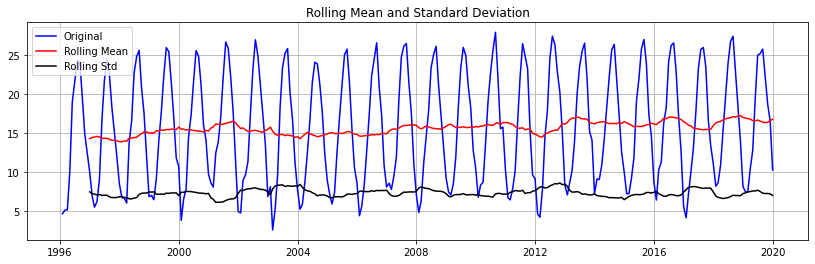

In [61]:
# run DFT on montly
dftest(monthly.AvgTemperature)
# p-value allows us to reject a unit root: data is stationary

Test Statistic           -4.091346
p-value                   0.001001
Lags Used                11.000000
Observations Used       276.000000
Critical Value (1%)      -3.454267
Critical Value (5%)      -2.872070
Critical Value (10%)     -2.572381
dtype: float64


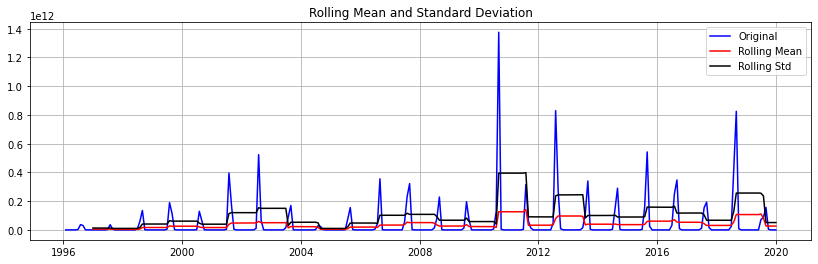

In [62]:
# here's an example of non-stationary with DFT results for monthly temperature

dftest(np.exp(monthly.AvgTemperature))

Nevertheless, the month level data is not stationary. 

Test Statistic           0.504645
p-value                  0.985014
Lags Used                8.000000
Observations Used       15.000000
Critical Value (1%)     -3.964443
Critical Value (5%)     -3.084908
Critical Value (10%)    -2.681814
dtype: float64


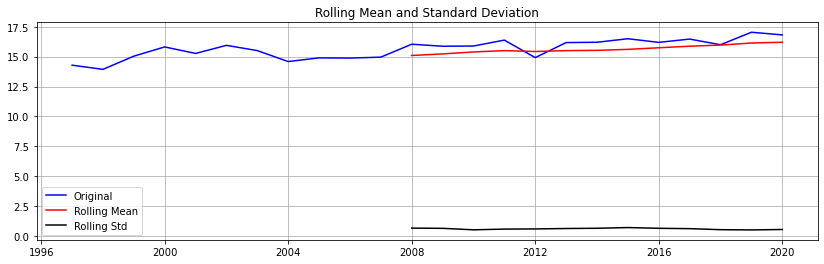

In [63]:
# run DFT on annual
dftest(annual.AvgTemperature)

Just so illustrate, we remove the seasonal effect and take the annual average. The graph shows that the lines are smooth, which indicates a stationary data set. 

Test Statistic           0.232503
p-value                  0.974027
Lags Used                9.000000
Observations Used       14.000000
Critical Value (1%)     -4.012034
Critical Value (5%)     -3.104184
Critical Value (10%)    -2.690987
dtype: float64


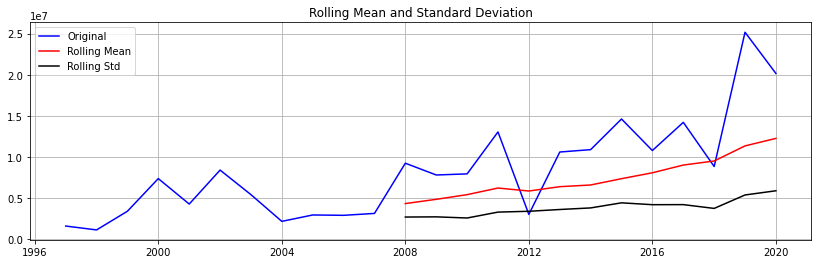

In [64]:
# here's an example of non-stationary with DFT results
dftest(np.exp(annual.AvgTemperature))

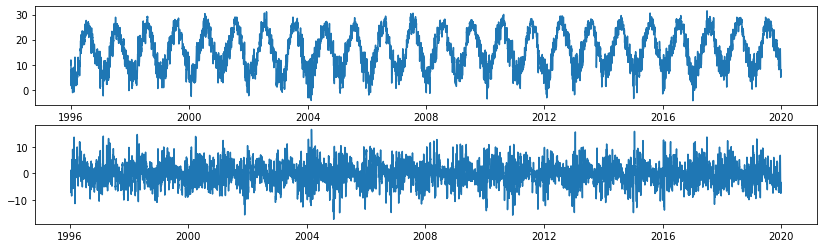

In [65]:
# Important to note that values have strong seasonality and adf test as well as rolling mean may not capture this.
# That is why it is always important to pay attention to run sequence plot
df['lag_12'] = df.shift(12)
df['seasonal_diff'] = df.AvgTemperature - df['lag_12']

fig,axes = plt.subplots(2,1)
axes[0].plot(df.AvgTemperature, label ='original')
axes[1].plot(df.seasonal_diff,label = 'seasonal diff')

Since our unit of analysis is day, we can aggrate it to monthly level. However, as we noticed above, montly level data is stationary and to fix this, we can take the log. We can also check the results in graphs whether everything looks fine. 

### Monthly temperature  

We have already created these graphs individually but seasonal decomposition function from the statsmodels library can do the same task with just a code. 

([<matplotlib.axis.XTick at 0x7fde15b1cb80>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

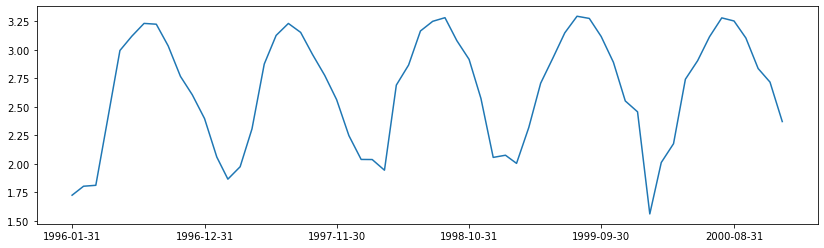

In [103]:
#given the difference in variance we should probably take log of data
monthly['log_tmp'] = np.log1p(monthly['AvgTemperature'])

# going to zoom in on last 60 values to get a better idea of frequency of seasonality
plt.plot(monthly['log_tmp'][:60])
plt.xticks(ticks = monthly.iloc[0:60:11].index)

In [106]:
monthly.tail()

,AvgTemperature,forecast,log_tmp
Date,,,
2019-08-31,25.777778,NaN,3.287572
2019-09-30,22.279630,NaN,3.147579
2019-10-31,18.707885,NaN,2.981019
2019-11-30,16.575926,NaN,2.866530
2019-12-31,10.232975,NaN,2.418854


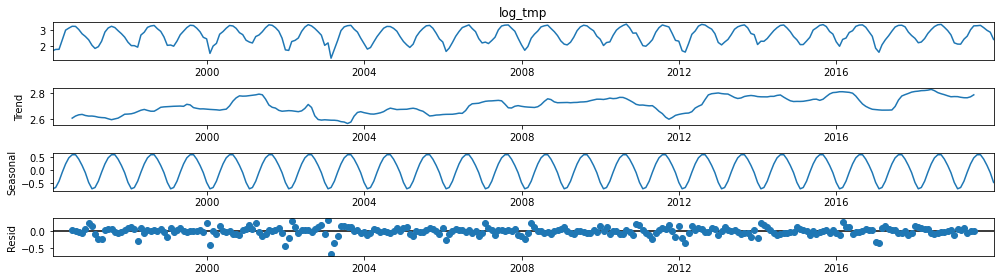

In [110]:
# plot decomposition with frequency 365 
# Seems to do decent job of capturing seasonality
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_decompose(monthly.log_tmp,freq=12).plot();

# Autofit Parameter search

R has an autoARIMA function (and other automagic methods) that gridsearches/optimizes our model hyperparameters for us. Over time, more of these goodies are porting to Python (e.g. pmdarima). While there's nothing wrong with utilizing these resources, the human makes the final determination! Don't become over-reliant on these methods, especially early on when you are grasping the underlying mechanics and theory!

In [112]:
#from pyramid.arima import auto_arima
stepwise_model = pm.auto_arima(monthly.log_tmp, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-112.021, Time=0.12 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-243.109, Time=0.30 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-113.453, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-133.936, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-256.529, Time=0.59 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.53 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-228.044, Time=0.35 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=-254.779, Time=0.67 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=-254.712, Time=0.98 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=-251.473, Time=0.52 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=-253.826, Time=1.58 sec
 ARIMA(1,0,0)(2,1,0)[12]             : 

In [113]:
stepwise_model.order

(1, 0, 0)

In [114]:
stepwise_model.seasonal_order

(1, 1, 2, 12)

In [115]:
stepwise_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  288
Model:             SARIMAX(1, 0, 0)x(1, 1, [1, 2], 12)   Log Likelihood                 162.274
Date:                                 Sun, 02 Jan 2022   AIC                           -314.548
Time:                                         00:14:58   BIC                           -296.446
Sample:                                              0   HQIC                          -307.284
                                                 - 288                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4019      0.049      8.229      0.000       0.306       0.498
ar.S.L12      -0.9045      0.060    -14.985      0.000      -1.023      -0.786
ma.S.L12      -0.0651      0.088     -0.740      0.459      -0.238       0.107
ma.S.L24      -0.7080      0.104     -6.797      0.000      -0.912      -0.504
sigma2         0.0168      0.001     17.449      0.000       0.015       0.019
===================================================================================
Ljung-Box (L1) (Q):                   0.70   Jarque-Bera (JB):               990.44
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                            -1.20
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

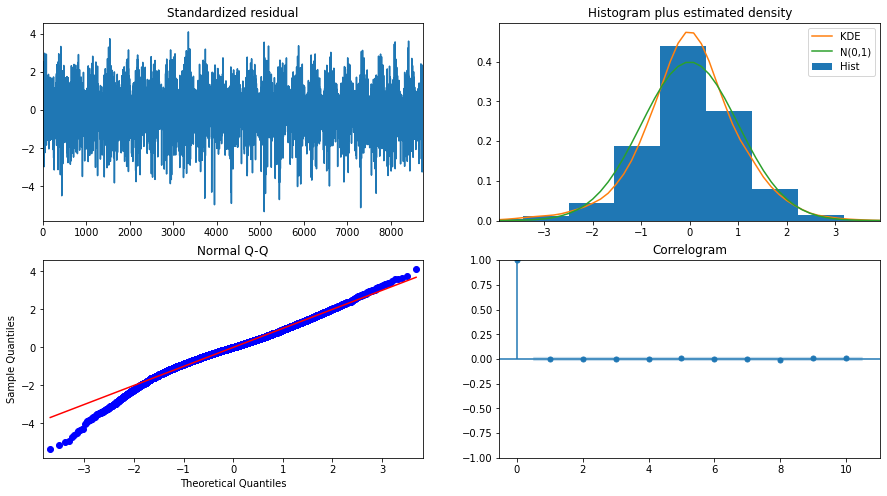

In [71]:
stepwise_model.plot_diagnostics(figsize=(15,8))
plt.show()

### Results 

Looking at the residual plots, we can say that:
- The residuals have a constant variance. 

- Model follows almost normal distribution.

- Majority of the dots lie on the red line in the Normal Q-Q plot so model is fitted well.

- The residuals are not auto correlated as there is no significant pattern.

# SARIMA with Statsmodels

When we work with SARIMA models 'S' refers to 'seasonal' and we have the additional standard inputs:

__seasonal order(p,d,q):__
- p is number of AR terms in regards to seasonal lag
- d is number of times that we would difference our seasonal lag (as seen above)
- q is number of MA terms in regards to seasonal lag
- s is number of periods in a season

__Some rules to highlight from the Duke ARIMA Guide:__

- If the series has positive autocorrelations out to a high number of lags, then it probably needs a higher order of differencing  

- If the lag-1 autocorrelation is zero or negative, or the autocorrelations are all small and patternless, then the series does not need a higher order of differencing. If the lag-1 autocorrelation is -0.5 or more negative, the series may be overdifferenced. BEWARE OF OVERDIFFERENCING!!  

- A model with no orders of differencing assumes that the original series is stationary (mean-reverting). A model with one order of differencing assumes that the original series has a constant average trend (e.g. a random walk or SES-type model, with or without growth). A model with two orders of total differencing assumes that the original series has a time-varying trend (e.g. a random trend or LES-type model)


In [116]:
# define helper plot function for visualization
def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    raw.plot(data)
    sm.tsa.graphics.plot_acf(data, lags=lags, ax=acf, zero=False)
    sm.tsa.graphics.plot_pacf(data, lags=lags, ax=pacf, zero = False)
    sns.despine()
    plt.tight_layout()

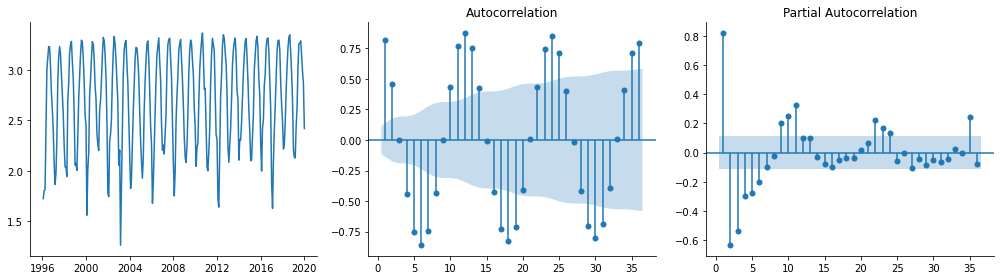

In [118]:
# helper plot for monthly temps
plots(monthly.log_tmp, lags=36);
# open Duke guide for visual
# we note a 12-period cycle (yearly) with suspension bridge design, so must use SARIMA

Due to seasonal tempreture change, there is a fluctation in data set but also we have a autocorrelation issue here. So, this indicates that we have a complicated model here. 

In [119]:
# we might need to install dev version for statespace functionality
#!pip install git+https://github.com/statsmodels/statsmodels.git

# fit SARIMA monthly based on helper plots
sar = sm.tsa.statespace.SARIMAX(monthly.log_tmp, 
                                order=(1,0,0), 
                                seasonal_order=(1, 1, 2, 12), 
                                trend='c').fit()
sar.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.62377D-01    |proj g|=  2.66142D+00


 This problem is unconstrained.



At iterate    5    f= -5.67679D-01    |proj g|=  1.45224D-01

At iterate   10    f= -5.75515D-01    |proj g|=  3.46458D-01

At iterate   15    f= -5.75753D-01    |proj g|=  1.35472D-01

At iterate   20    f= -5.77462D-01    |proj g|=  2.68831D-01

At iterate   25    f= -5.77744D-01    |proj g|=  1.95750D-01

At iterate   30    f= -5.82905D-01    |proj g|=  9.05471D-02

At iterate   35    f= -5.84671D-01    |proj g|=  2.98260D-02

At iterate   40    f= -5.84727D-01    |proj g|=  1.85761D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     51      1     0     0   4.670D-04  -5.847D-01
  F = -0.584727914099

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                 log_tmp   No. Observations:                  288
Model:             SARIMAX(1, 0, 0)x(1, 1, [1, 2], 12)   Log Likelihood                 168.402
Date:                                 Sun, 02 Jan 2022   AIC                           -324.803
Time:                                         00:16:28   BIC                           -303.081
Sample:                                     01-31-1996   HQIC                          -316.086
                                          - 12-31-2019                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0083      0.002      3.787      0.000       0.004       0.013
ar.L1          0.3584      0.047      7.621      0.000       0.266       0.451
ar.S.L12      -0.9002      0.067    -13.351      0.000      -1.032      -0.768
ma.S.L12      -0.1776      0.299     -0.594      0.552      -0.763       0.408
ma.S.L24      -0.7975      0.319     -2.500      0.012      -1.423      -0.172
sigma2         0.0151      0.005      3.176      0.001       0.006       0.024
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               762.65
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                            -1.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

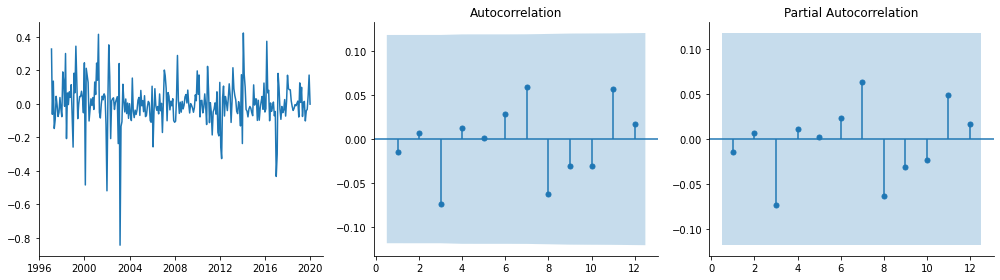

In [120]:
# plot resids
plots(sar.resid[sar.loglikelihood_burn:], lags=12);

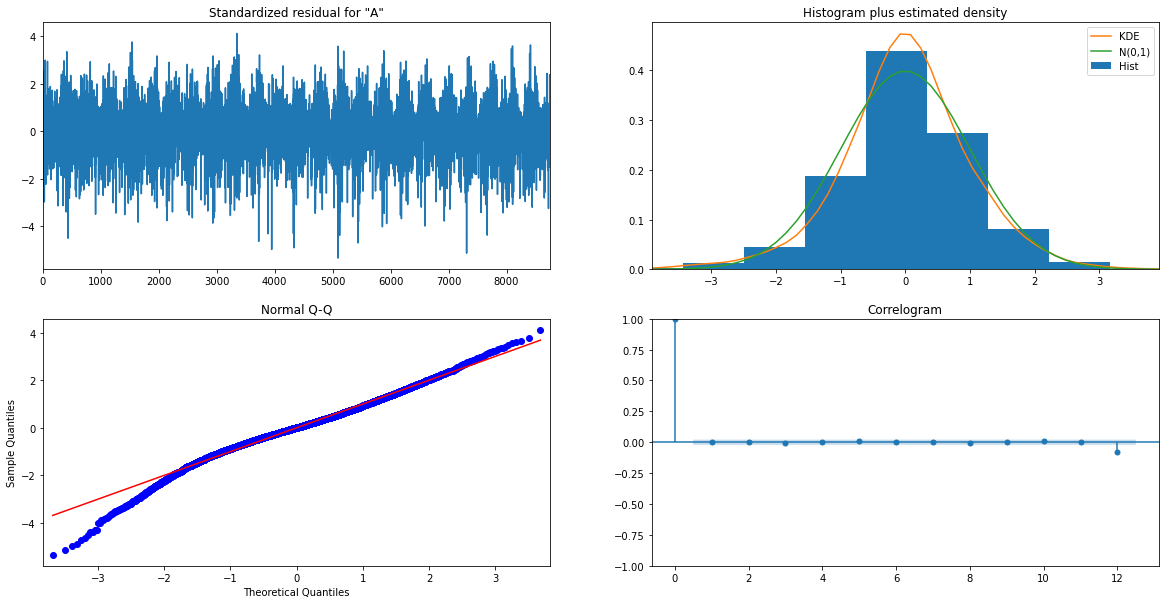

In [77]:
# plot residual diagnostics
sar.plot_diagnostics(lags=12,figsize = (20,10),);

__Interpretation of plots:__ Basically, all these residual plots shows that our model fits well for time series analysis and its time to show our prediction scores. First, we can plot how our model is good at predicting actual scores and then we can forecast the future scores based on this model. 

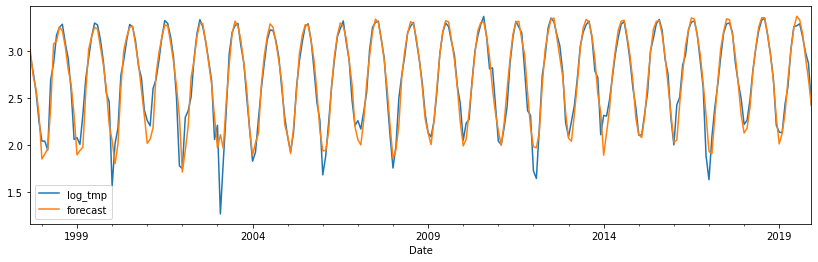

In [145]:
# plot predictions
pd.plotting.register_matplotlib_converters()

#use model.predict() start and end in relation to series
monthly['forecast'] = sar.predict(start = 5, end= 300)  
monthly[20:][['log_tmp', 'forecast']].plot();

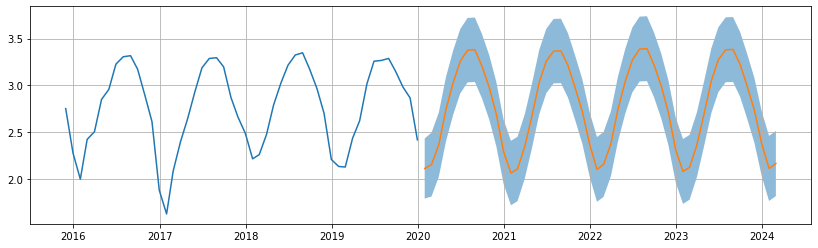

In [146]:
# can use get forecast to create a forecast object
future_fcst = sar.get_forecast(50)
# That will have a method to pull in confidence interval 
confidence_int = future_fcst.conf_int(alpha = 0.01)
# Has an attribute to pull in predicted mean
fcst = future_fcst.predicted_mean
# Plot predictions and confidence intervals
plt.plot(monthly.log_tmp[-50:])
plt.plot(fcst)
plt.fill_between(confidence_int.index,confidence_int['lower log_tmp'],confidence_int['upper log_tmp'],alpha = 0.5)
plt.grid()

# Statistical Tests

- Normality (Jarque-Bera)
    - Null hypothesis is normally distributed residuals (good, plays well with RMSE and similar error metrics)

- Serial correlation (Ljung-Box)
    - Null hypothesis is no serial correlation in residuals (independent of each other)

- Heteroskedasticity
    - Tests for change in variance between residuals.
    - The null hypothesis is no heteroskedasticity. That means different things depending on which alternative is selected:
        - Increasing: Null hypothesis is that the variance is not increasing throughout the sample; that the sum-of-squares in the later subsample is not greater than the sum-of-squares in the earlier subsample.
        - Decreasing: Null hypothesis is that the variance is not decreasing throughout the sample; that the sum-of-squares in the earlier subsample is not greater than the sum-of-squares in the later subsample.
        - Two-sided (default): Null hypothesis is that the variance is not changing throughout the sample. Both that the sum-of-squares in the earlier subsample is not greater than the sum-of-squares in the later subsample and that the sum-of-squares in the later subsample is not greater than the sum-of-squares in the earlier subsample.

- Durbin Watson
    - Tests autocorrelation of residuals: we want between 1-3, 2 is ideal (no serial correlation)


### Normality test

In [129]:
# create and run statistical tests on model
norm_val, norm_p, skew, kurtosis = sar.test_normality('jarquebera')[0]
lb_val, lb_p = sar.test_serial_correlation(method='ljungbox',)[0]
het_val, het_p = sar.test_heteroskedasticity('breakvar')[0]


# we want to look at largest lag for Ljung-Box, so take largest number in series
# there's intelligence in the method to determine how many lags back to calculate this stat
lb_val = lb_val[-1]
lb_p = lb_p[-1]
durbin_watson = sm.stats.stattools.durbin_watson(
    sar.filter_results.standardized_forecasts_error[0, sar.loglikelihood_burn:])

print('Normality: val={:.3f}, p={:.3f}'.format(norm_val, norm_p));
print('Ljung-Box: val={:.3f}, p={:.3f}'.format(lb_val, lb_p));
print('Heteroskedasticity: val={:.3f}, p={:.3f}'.format(het_val, het_p));
print('Durbin-Watson: d={:.2f}'.format(durbin_watson))

Normality: val=762.651, p=0.000
Ljung-Box: val=8.523, p=0.998
Heteroskedasticity: val=0.503, p=0.001
Durbin-Watson: d=1.99


### Cross validation

In [184]:
def cross_validate(series,horizon,start,step_size,order = (1,0,0),seasonal_order = (0,0,0,0),trend=None):
    '''
    Function to determine in and out of sample testing of arima model    
    
    arguments
    ---------
    series (seris): time series input
    horizon (int): how far in advance forecast is needed
    start (int): starting location in series
    step_size (int): how often to recalculate forecast
    order (tuple): (p,d,q) order of the model
    seasonal_order (tuple): (P,D,Q,s) seasonal order of model
    
    Returns
    -------
    DataFrame: gives fcst and actuals with date of prediction
    '''
    fcst = []
    actual = []
    date = []
    for i in range(start,len(series)-horizon,step_size):
        model = sm.tsa.statespace.SARIMAX(series[:i+1], #only using data through to and including start 
                                order=order, 
                                seasonal_order=seasonal_order, 
                                trend=trend).fit(disp=0) # supress result visualization
        fcst.append(model.forecast(steps = horizon)[-1]) #forecasting horizon steps into the future
        actual.append(series[i+horizon]) # comparing that to actual value at that point
        date.append(series.index[i+horizon]) # saving date of that value
    return pd.DataFrame({'fcst':fcst,'actual':actual},index=date)

In [185]:
warnings.filterwarnings("ignore")
series = monthly.log_tmp
horizon = 12
start = 100
step_size = 3
order = (1,0,0)
seasonal_order = (1,1,2,12)

cv = cross_validate(monthly.log_tmp,12,100,3,
                    order = order,
                    seasonal_order = seasonal_order)

In [186]:
cv.head()

,fcst,actual
2005-05-31,2.914648,2.891466
2005-08-31,3.251052,3.287238
2005-11-30,2.555282,2.450047
2006-02-28,1.978158,1.879404
2006-05-31,2.909647,2.909210


<AxesSubplot:title={'center':'forecast every three months using one year prior data'}>

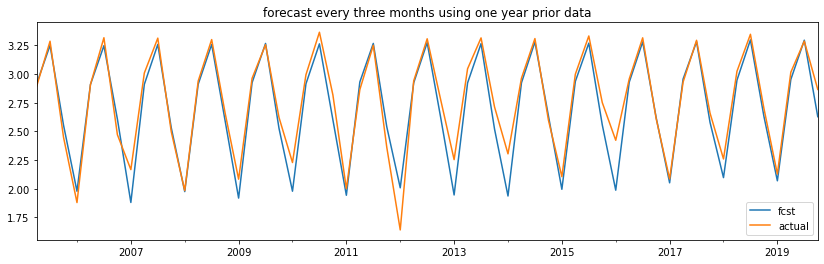

In [187]:
cv.plot(title = 'forecast every three months using one year prior data')

In [188]:
#Defining an error metric to see out of sample accuracy
def mape(df_cv):
    return abs(df_cv.actual - df_cv.fcst).sum() / df_cv.actual.sum()

In [189]:
mape(cv)

0.03619671605607341

In [190]:
warnings.filterwarnings("ignore")
series = monthly.log_tmp
horizon = 12
start = 100
step_size = 3
order = (1,1,0)
seasonal_order = (0,1,1,12)

cv2 = cross_validate(monthly.log_tmp,12,100,3,
                    order = order,
                    seasonal_order = seasonal_order)

In [182]:
mape(cv2)

0.04226650013011019

<AxesSubplot:title={'center':'forecast every three months using one year prior data'}>

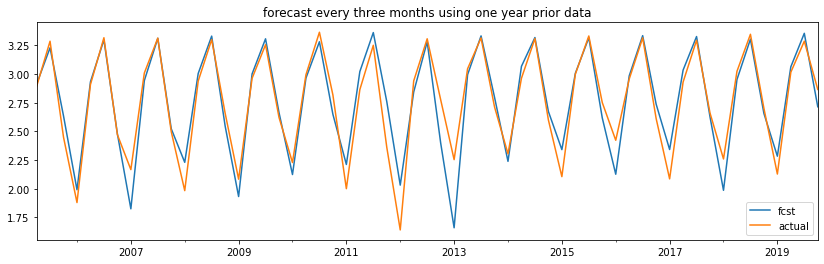

In [191]:
cv2.plot(title = 'forecast every three months using one year prior data')

With the grid search, our initial parameters still produces better results. 

# Summary

- First we processed the data and used some visualizations to give an insight about the data.
- We aggregated data to the monthly level data for the time series analysis.
- Since our data is not stationary, we need to take the log of temperature.
- To determine the parameters, we used autofit model and identified the lowest AIC scores. This parameters provides satisfactory results in prediction results. 
- Our model is pretty well to predict the future temperature for Istanbul. However, our model predicts the temperature lower on some extreme edges. When we apply the cross-validation, we manage to reduce this fluctations and our prediction model produces a little bit higher scores on edges. 
- We also applied normality tests and we got satisfactory results.  
- We also make cross-validation and improve the model. 
- We also created alternative models to compare the results and autofit model produces better results. 
- I will also use FB prophet and deep learning models for the same data to compare the results. If you would like to see which model produce better results, you can read my other posts. 

Please feel free to share your comments. 